# Initialization. Load previous state. Load modules

In [1]:
import dill
# Restore the entire session
dill.load_session('PTRMS_class_all.db')

In [2]:
#check last result on disk
print()

In [14]:
import pandas as pd
import numpy as np
#import cupy as cp

from sklearn.metrics import accuracy_score
#from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

#from tabpfn import TabPFNClassifier
#from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC



In [41]:
#PLS-DA, implemented using sklearn PLS and PDA functions
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.cross_decomposition import PLSRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

class PLSDA_Classifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_components=2):
        """
        A classifier that combines PLS for dimensionality reduction
        followed by LDA for classification.
        
        Parameters:
        ----------
        n_components: int
            Number of PLS components to use.
        """
        self.n_components = n_components
    
    def fit(self, X, y):
        """
        Fit the PLSDA classifier.

        Parameters:
        ----------
        X : array-like, shape (n_samples, n_features)
            Training data.

        y : array-like, shape (n_samples,)
            Target labels.
        """
        # Validate input
        X, y = check_X_y(X, y)
        self.classes_ = np.unique(y)
        
        # Fit the PLS for dimensionality reduction
        self.pls_ = PLSRegression(n_components=self.n_components)
        X_reduced = self.pls_.fit(X, y).x_scores_

        # Fit the LDA for classification
        self.lda_ = LinearDiscriminantAnalysis()
        self.lda_.fit(X_reduced, y)
        
        return self

    def predict(self, X):
        """
        Predict labels for given data.

        Parameters:
        ----------
        X : array-like, shape (n_samples, n_features)
            Input data.

        Returns:
        -------
        y_pred : array, shape (n_samples,)
            Predicted labels.
        """
        # Check if the model is fitted
        check_is_fitted(self, ["pls_", "lda_"])
        
        # Transform the data with PLS
        X = check_array(X)
        X_reduced = self.pls_.transform(X)
        
        # Predict using LDA
        return self.lda_.predict(X_reduced)

    def predict_proba(self, X):
        """
        Predict class probabilities for X.

        Parameters:
        ----------
        X : array-like, shape (n_samples, n_features)
            Input data.

        Returns:
        -------
        proba : array, shape (n_samples, n_classes)
            Predicted probabilities.
        """
        # Check if the model is fitted
        check_is_fitted(self, ["pls_", "lda_"])
        
        # Transform the data with PLS
        X = check_array(X)
        X_reduced = self.pls_.transform(X)
        
        # Predict probabilities using LDA
        return self.lda_.predict_proba(X_reduced)


In [41]:
#PLS-DA, implemented using sklearn PLS and PDA functions
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.cross_decomposition import PLSRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

class PLSDA_Classifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_components=2):
        """
        A classifier that combines PLS for dimensionality reduction
        followed by LDA for classification.
        
        Parameters:
        ----------
        n_components: int
            Number of PLS components to use.
        """
        self.n_components = n_components
    
    def fit(self, X, y):
        """
        Fit the PLSDA classifier.

        Parameters:
        ----------
        X : array-like, shape (n_samples, n_features)
            Training data.

        y : array-like, shape (n_samples,)
            Target labels.
        """
        # Validate input
        X, y = check_X_y(X, y)
        self.classes_ = np.unique(y)
        
        # Fit the PLS for dimensionality reduction
        self.pls_ = PLSRegression(n_components=self.n_components)
        X_reduced = self.pls_.fit(X, y).x_scores_

        # Fit the LDA for classification
        self.lda_ = LinearDiscriminantAnalysis()
        self.lda_.fit(X_reduced, y)
        
        return self

    def predict(self, X):
        """
        Predict labels for given data.

        Parameters:
        ----------
        X : array-like, shape (n_samples, n_features)
            Input data.

        Returns:
        -------
        y_pred : array, shape (n_samples,)
            Predicted labels.
        """
        # Check if the model is fitted
        check_is_fitted(self, ["pls_", "lda_"])
        
        # Transform the data with PLS
        X = check_array(X)
        X_reduced = self.pls_.transform(X)
        
        # Predict using LDA
        return self.lda_.predict(X_reduced)

    def predict_proba(self, X):
        """
        Predict class probabilities for X.

        Parameters:
        ----------
        X : array-like, shape (n_samples, n_features)
            Input data.

        Returns:
        -------
        proba : array, shape (n_samples, n_classes)
            Predicted probabilities.
        """
        # Check if the model is fitted
        check_is_fitted(self, ["pls_", "lda_"])
        
        # Transform the data with PLS
        X = check_array(X)
        X_reduced = self.pls_.transform(X)
        
        # Predict probabilities using LDA
        return self.lda_.predict_proba(X_reduced)


In [35]:
def predict_class_by_label(IDs, y, X, classifier, param_grid={}, cv=5, gpu=False, verbose=True):
    """
    Calculates predictions for test sets, each with a unique label in IDs, and selects the best parameters using GridSearchCV.

    Args:
        IDs: A pandas Series containing labels.
        y: A pandas Series or numpy array containing target labels.
        X: A pandas DataFrame or numpy array containing features.
        classifier: A scikit-learn classifier class.
        param_grid: A dictionary specifying parameter options for GridSearchCV.
        cv: Number of folds for cross-validation. If cv=0 it directly tunes a single model
        gpu: If True, move X to gpu before training.
        verbose: If True, prints progress and metrics.

    Returns:
        predictions: Predictions for y as test sets.
        classification error.
        best_params_per_label: Dictionary with the best parameters for each label.
    """
    unique_labels = IDs.unique()
    best_params_per_label = {}
    
    # Ensure X and y are numpy arrays for compatibility
    if not isinstance(X, np.ndarray):
        X = X.to_numpy()
    if not isinstance(y, np.ndarray):
        y = y.to_numpy()

    predictions = y[:]*0

    for label in unique_labels:
        mask = (IDs == label)
            
        if gpu:
            X_train, X_test = cp.array(X[~mask]), cp.array(X[mask])
        else:
            X_train, X_test = X[~mask], X[mask]            
        y_train, y_test = y[~mask], y[mask]
        
        if cv>1:
            # Use GridSearchCV to find the best parameters
            grid_search = GridSearchCV(
                estimator=classifier(),
                param_grid=param_grid,
                scoring='accuracy',
                cv=cv,
                verbose=verbose
            )
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_

            # Store the best parameters
            best_params_per_label[label] = grid_search.best_params_

        else:
            best_model = classifier(**param_grid)
            best_model.fit(X_train, y_train)
            best_params_per_label[label] = param_grid
    
        # Predict on the test set
        predictions[mask] = best_model.predict(X_test)
 
        if verbose:
            print(f"Label: {label}, Best Params: {best_params_per_label[label]}")
            print(f"Test Set error for label {label}: {round(1.0-accuracy_score(y_test, predictions[mask]), 4)}")

    # Final metrics
    final_error = 1.0-accuracy_score(y, predictions)
    
    if verbose:
        print(f"\nOverall Classification Error: {round(final_error, 4)}")

    return predictions, final_error, best_params_per_label


# Load datasets froms .scv

In [17]:
# Load the Tea data
tabla = pd.read_csv("TEA15_brew_matrix_0.1 ppb.csv", header=0)  # Assuming the first row contains headers

# Extract the relevant columns
Xm = tabla.iloc[:, 7:]

# Calculate row sums
suma = Xm.sum(axis=1)

# Normalize the data
XmN = Xm.div(suma, axis=0)

# Create a factor for origin by country
O_big = tabla.iloc[:, 1]
N_r = tabla.iloc[:, 0].str[:5]

# Filter data for 4 origins
mask = (O_big == "Chi") | (O_big == "Ind") | (O_big == "Sri") | (O_big == "Jap")

tea_X = XmN[mask]
tea_y = pd.factorize(O_big[mask])[0]
tea_ID = N_r[mask]

In [18]:
# Load the GUM data
tabla = pd.read_csv("GUM24_mezclas.csv", header=0, decimal=",")  # Assuming the first row contains headers

# Extract the relevant columns
Xm = tabla.iloc[:, 9:]

# Calculate row sums
suma = Xm.sum(axis=1)

# Normalize the data
XmN = Xm.div(suma, axis=0)

Nm_comp = tabla.iloc[:, 0]

Tm2 = (tabla.iloc[:, 4] > 0).astype(int) 
Tm3 = (tabla.iloc[:, 5] > 0).astype(int) 

gum2_ID=Nm_comp
gum2_y=Tm2
gum2_X=XmN

gum3_ID=Nm_comp
gum3_y=Tm3
gum3_X=XmN

In [19]:
# Load the CAFE data
tabla = pd.read_csv("Cafe14_powder_O2.csv", header=0, decimal=".")  # Assuming the first row contains headers

# Extract the relevant columns
Xm = tabla.iloc[:, 1:]

# Calculate row sums
suma = Xm.sum(axis=1)

# Normalize the data
XmN = Xm.div(suma, axis=0)

# Extract the first 7 characters from the first column
N_r = tabla.iloc[:, 0].str[:7] 

# Create a factor with 6 levels, repeating each level 6 times
T6 = np.repeat(np.arange(0, 6), 6) 


cafe_ID=N_r
cafe_y=T6
cafe_X=XmN

In [20]:
#Load Funghi20 tabla

tabla = pd.read_csv("Funghi20.csv", header=0, decimal=".", sep=';')  # Assuming the first row contains headers

tabla = tabla[tabla.iloc[:, 4] != "BLNK"]

# Remove rows where the 4th column has specific values
tabla = tabla[~tabla.iloc[:, 3].isin(["GE", "ME-ve", "ME+ve", "PDA", "ZO", "M4"])]

# Replace "Al1" in the 3rd column with "AL1" (assuming a typo)
mask = (tabla.iloc[:, 2] == 'Al1')
tabla.iloc[mask, 2] = 'AL1'

# Extract the relevant columns
Xm = tabla.iloc[:, 8:]

# Calculate row sums
suma = Xm.sum(axis=1)

# Normalize the tabla
XmN = Xm.div(suma, axis=0)

Nm_comp = tabla.iloc[:, 2]

#clase para cada tipo
# AL BA EX GA GL HO HU M2 PA PZ SI VE
T12 = pd.factorize(tabla.iloc[: ,3])[0]

fu20_ID=Nm_comp
fu20_y=T12
fu20_X=XmN

In [21]:
#Load Funghi21 tabla

tabla = pd.read_csv("Funghi21.csv", header=0, decimal=".", sep=';')  # Assuming the first row contains headers

tabla = tabla.iloc[:633, :]
print(tabla.shape)

tabla = tabla[tabla.iloc[:, 11] == "funghi"]
print(tabla.shape)  # Salida esperada: (598, 398)

# Filtrar las filas donde la columna 14 sea igual a "no"
tabla = tabla[tabla.iloc[:, 13] == "no"]
print(tabla.shape)  # Salida esperada: (594, 398)

# Eliminar la fila número 32 del index leido (nan)
tabla = tabla.drop(index=32)
# Remove rows where the 4th column has specific values

# Extract the relevant columns
Xm = tabla.drop(columns=tabla.columns[list(range(14)) + [15]])

# Calculate row sums
suma = Xm.sum(axis=1)

# Normalize the tabla
XmN = Xm.div(suma, axis=0)

Nm_comp = tabla.iloc[:, 5].astype(str) + "_" + tabla.iloc[:, 6].astype(str) + "_" + tabla.iloc[:, 9].astype(str)

#clase para cada tipo
T6 = pd.factorize(tabla.iloc[: ,5])[0]

fu21_ID=Nm_comp
fu21_y=T6
fu21_X=XmN

(633, 398)
(598, 398)
(594, 398)


In [22]:
#datos de funghi del 2013, no se el origen
tabla = pd.read_csv("FUNGHI13_ARMILLARIA_Sola.csv", header=0, decimal=",", sep=';')

# Extract the relevant columns
Xm = tabla.iloc[:, 3:]

# Calculate row sums
suma = Xm.sum(axis=1)

# Normalize the tabla
XmN = Xm.div(suma, axis=0)

N_r = tabla.iloc[:, 1].astype(str)

# Eliminar el último carácter de cada string
N_r = N_r.str[:-1]

N_r.iloc[40] = N_r.iloc[41]

#clase para cada tipo
T6 = pd.factorize(tabla.iloc[: ,2])[0]

fu13_ID=N_r
fu13_y=T6
fu13_X=XmN

In [23]:
#Jam
#datos de jamones del 2013, esta el paper
tabla = pd.read_csv("JAM13_JamItal3raz.csv", header=0, decimal=",", sep=';').iloc[:54, :]

# Extract the relevant columns
Xm = tabla.iloc[:, 4:]
# Calculate row sums
suma = Xm.sum(axis=1)
# Normalize the tabla
XmN = Xm.div(suma, axis=0)

N_r = tabla.iloc[:, 1].astype(str)

# Eliminar el último carácter de cada string
N_r = N_r.str[:-1]

N_r.iloc[40] = N_r.iloc[41]

#clase para cada tipo
T3 = pd.factorize(tabla.iloc[: ,3])[0]

jam_ID=N_r
jam_y=T3
jam_X=XmN

In [24]:
#peperoncini sisters 24
tabla = pd.read_csv("Analysis_peperoni_SHS.mldatx_results_ppbv_H3O.csv", header=0, decimal=".")
tabla = tabla[~tabla.iloc[:, 0].str[:4].eq("BLNK")]
tabla = tabla.iloc[:192,:]
# Extract the relevant columns
Xm = tabla.drop(columns=tabla.columns[[0, 1, 8, 256]])
# Calculate row sums
suma = Xm.sum(axis=1)
# Normalize the tabla
XmN = Xm.div(suma, axis=0)

Gm = tabla.iloc[:, 0].astype(str)

# Crear Nm_comp eliminando los últimos 2 caracteres de cada string en Gm
Nm_comp = Gm.str[:-2]

# Clase para cada tipo: T2 basado en los primeros 2 caracteres de Gm
#T2 = pd.factorize(Gm.str[:2])[0] + 1  # `+1` para que los factores comiencen en 1 como en R

# Clase para cada tipo: T4 basado en los primeros 4 caracteres de Gm
T4 = pd.factorize(Gm.str[:4])[0]

# Modificar TT2 basado en T4
TT2 = T4.copy()
TT2[TT2 == 2] = 0
TT2[TT2 == 3] = 1
TT2 = pd.factorize(TT2)[0]

# Filtrar XmN basado en TT2
XmN20 = XmN[TT2 == 0]

# Crear T20 basado en los valores de T4 donde TT2 es igual a 1
T20 = pd.factorize(T4[TT2 == 0])[0]

# Filtrar Nm_comp basado en TT2 igual a 1
Nm_comp20 = Nm_comp[TT2 == 0]

pep_ID=Nm_comp20
pep_y=T20
pep_X=XmN20

In [25]:
#spinaci Sisters
tabla = pd.read_csv("Analysis_spinaci_SHS.mldatx_results_ppbv_H3O.csv", header=0, decimal=".",sep=";")
tabla = tabla[~tabla.iloc[:, 1].eq("BLNK")]
tabla = tabla[~tabla.iloc[:, 1].eq("STF")]
tabla = tabla[~tabla.iloc[:, 1].eq("SA")]
print(tabla.shape)
#72x342

# Extract the relevant columns
Xm = tabla.iloc[:,9:]
# Calculate row sums
suma = Xm.sum(axis=1)
# Normalize the tabla
XmN = Xm.div(suma, axis=0)

Gm = tabla.iloc[:, 0].astype(str)
Nm_comp = Gm.str[:-2]

T2 = pd.factorize(tabla.iloc[:,1])[0]

spi_ID=Nm_comp
spi_y=T2
spi_X=XmN

(72, 342)


In [26]:
#pesce
tabla = pd.read_csv("Pesce.csv", header=0, decimal=".",sep=";")
tabla = tabla.iloc[:117, :]
tabla = tabla[tabla.iloc[:, 4].eq("FISH")]
print(tabla.shape)
#104 267

# Extract the relevant columns
Xm = tabla.iloc[:,8:]
# Calculate row sums
suma = Xm.sum(axis=1)
# Normalize the tabla
XmN = Xm.div(suma, axis=0)

Nm_comp = tabla.iloc[:, 1].astype(str) + tabla.iloc[:, 7].astype(str)

T3 = pd.factorize(tabla.iloc[:,3])[0]

pes_ID=Nm_comp
pes_y=T3
pes_X=XmN

(104, 267)


# Train methods

## Tea

In [38]:
#Tea
IDs = tea_ID
y = tea_y
X=tea_X

In [43]:
#PLS-DA (PLS+LDA)
param_grid = {
    'n_components':[2,3,4,5,6,7,8]
}
predict_PLSDA  = predict_class_by_label(cv=3,IDs=IDs, y=y, X=X,classifier=PLSDA_Classifier, param_grid = param_grid,verbose=True)
print(predict_PLSDA[1])

Fitting 3 folds for each of 7 candidates, totalling 21 fits
Label: Chi_A, Best Params: {'n_components': 7}
Test Set error for label Chi_A: 0.6
Fitting 3 folds for each of 7 candidates, totalling 21 fits
Label: Chi_H, Best Params: {'n_components': 8}
Test Set error for label Chi_H: 0.4167
Fitting 3 folds for each of 7 candidates, totalling 21 fits
Label: Chi_N, Best Params: {'n_components': 3}
Test Set error for label Chi_N: 0.4583
Fitting 3 folds for each of 7 candidates, totalling 21 fits
Label: Chi_S, Best Params: {'n_components': 3}
Test Set error for label Chi_S: 0.0
Fitting 3 folds for each of 7 candidates, totalling 21 fits
Label: Chi_Y, Best Params: {'n_components': 7}
Test Set error for label Chi_Y: 0.6042
Fitting 3 folds for each of 7 candidates, totalling 21 fits
Label: Sri_D, Best Params: {'n_components': 3}
Test Set error for label Sri_D: 1.0
Fitting 3 folds for each of 7 candidates, totalling 21 fits
Label: Sri_N, Best Params: {'n_components': 8}
Test Set error for label S

In [32]:
predict_PLSDA_tea = predict_PLSDA

In [116]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

#SVM-c
param_grid = {
    'kernel':['linear'],
    'C':[0.01,0.1,1.0,10,100,1000,10000,100000],
    'degree':[3],
    'gamma':['scale']
}
predict_SVM  = predict_class_by_label(cv=3,IDs=IDs, y=y, X=scaler.fit_transform(X),classifier=SVC, param_grid = param_grid,verbose=True)
print(predict_SVM[1])

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Label: Chi_A, Best Params: {'C': 1.0, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Test Set error for label Chi_A: 0.3667
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Label: Chi_H, Best Params: {'C': 1.0, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Test Set error for label Chi_H: 0.0
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Label: Chi_N, Best Params: {'C': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Test Set error for label Chi_N: 0.5
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Label: Chi_S, Best Params: {'C': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Test Set error for label Chi_S: 0.0
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Label: Chi_Y, Best Params: {'C': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Test Set error for label Chi_Y: 0.625
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Label: 

In [31]:
predict_SVM_tea = predict_SVM

In [33]:
#PDA (LDA regularized)
param_grid = {
    'solver':'lsqr', 
    'shrinkage':'auto'
}
predict_PDA  = predict_class_by_label(cv=0,IDs=IDs, y=y, X=X,classifier=LinearDiscriminantAnalysis, param_grid = param_grid,verbose=False)
print(predict_PDA[1])

0.5


In [34]:
predict_PDA_tea = predict_PDA

In [ ]:
#RF
param_grid = {
    'n_estimators': 1000,
    'max_features':'sqrt'
}
predict_RF  = predict_class_by_label(cv=0,IDs=IDs, y=y, X=X,classifier=RandomForestClassifier, param_grid = param_grid,verbose=True)
print(predict_RF[1])

In [ ]:
predict_RF_tea = predict_RF

In [ ]:
#tabPFN
param_grid = {
    'ignore_pretraining_limits':True
}
predict_tabPFN  = predict_class_by_label(cv=0,IDs=IDs, y=y, X=X,classifier=TabPFNClassifier, param_grid = param_grid,verbose=False)
print(predict_tabPFN[1])


In [ ]:
predict_TabPFN_tea = predict_tabPFN

In [155]:
%%time
#XGBoost
param_grid = {
    'device':['cpu'],
    'n_estimators': [1000], 
    'eta':[0.25,0.10,0.05], 
    'max_depth':[1,3,5], 
    'subsample':[1,0.8,0.6], 
    'colsample_bytree':[1,0.75,0.5]
}
predict_XGB = predict_class_by_label(cv=3,gpu=False,IDs=IDs, y=y, X=X,classifier=XGBClassifier, param_grid = param_grid,verbose=True)
print(predict_XGB[1])

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Label: Chi_A, Best Params: {'colsample_bytree': 1, 'device': 'cpu', 'eta': 0.25, 'max_depth': 5, 'n_estimators': 1000, 'subsample': 0.6}
Test Set error for label Chi_A: 0.2
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Label: Chi_H, Best Params: {'colsample_bytree': 1, 'device': 'cpu', 'eta': 0.25, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 1}
Test Set error for label Chi_H: 0.3333
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Label: Chi_N, Best Params: {'colsample_bytree': 1, 'device': 'cpu', 'eta': 0.05, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 1}
Test Set error for label Chi_N: 0.375
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Label: Chi_S, Best Params: {'colsample_bytree': 0.5, 'device': 'cpu', 'eta': 0.1, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 1}
Test Set error for label Chi_S: 0.0
Fitting 3 folds for each of 81 candidates, totalling 243 fit

In [156]:
predict_XGB_tea = predict_XGB

In [157]:
dill.dump_session('PTRMS_class_all.db')

## Gum2

In [158]:
#Gum2
IDs = gum2_ID
y = gum2_y
X=gum2_X

In [119]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

#SVM-c
param_grid = {
    'kernel':['linear'],
    'C':[0.01,0.1,1.0,10,100,1000,10000,100000],
    'degree':[3],
    'gamma':['scale']
}
predict_SVM  = predict_class_by_label(cv=3,IDs=IDs, y=y, X=scaler.fit_transform(X),classifier=SVC, param_grid = param_grid,verbose=True)
print(predict_SVM[1])

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Label: GB_14, Best Params: {'C': 0.1, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Test Set error for label GB_14: 0.0
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Label: GB_12, Best Params: {'C': 0.1, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Test Set error for label GB_12: 0.0
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Label: GB_21, Best Params: {'C': 0.1, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Test Set error for label GB_21: 0.0
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Label: GB_8, Best Params: {'C': 0.1, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Test Set error for label GB_8: 0.0
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Label: GB_2, Best Params: {'C': 0.1, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Test Set error for label GB_2: 0.0
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Label: GB_20, Best 

In [120]:
predict_SVM_gum2 = predict_SVM

In [36]:
#PDA (LDA regularized)
param_grid = {
    'solver':'lsqr', 
    'shrinkage':'auto'
}
predict_PDA  = predict_class_by_label(cv=0,IDs=IDs, y=y, X=X,classifier=LinearDiscriminantAnalysis, param_grid = param_grid,verbose=False)
print(predict_PDA[1])

0.12734082397003743


In [37]:
predict_PDA_gum2 = predict_PDA

In [ ]:
#RF
param_grid = {
    'n_estimators': 1000,
    'max_features':'sqrt'
}
predict_RF  = predict_class_by_label(cv=0,IDs=IDs, y=y, X=X,classifier=RandomForestClassifier, param_grid = param_grid,verbose=True)
print(predict_RF[1])

In [ ]:
predict_RF_gum2 = predict_RF

In [ ]:
#tabPFN
param_grid = {
    'ignore_pretraining_limits':True
}
predict_tabPFN  = predict_class_by_label(cv=0,IDs=IDs, y=y, X=X,classifier=TabPFNClassifier, param_grid = param_grid,verbose=False)
print(predict_tabPFN[1])


In [ ]:
predict_TabPFN_gum2 = predict_tabPFN

In [159]:
#XGBoost
param_grid = {
    'device':['cpu'],
    'n_estimators': [1000], 
    'eta':[0.25,0.10,0.05], 
    'max_depth':[1,3,5], 
    'subsample':[1,0.8,0.6], 
    'colsample_bytree':[1,0.75,0.5]
}
predict_XGB = predict_class_by_label(cv=3,gpu=False,IDs=IDs, y=y, X=X,classifier=XGBClassifier, param_grid = param_grid,verbose=True)
print(predict_XGB[1])

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Label: GB_14, Best Params: {'colsample_bytree': 0.5, 'device': 'cpu', 'eta': 0.1, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.6}
Test Set error for label GB_14: 0.0
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Label: GB_12, Best Params: {'colsample_bytree': 0.5, 'device': 'cpu', 'eta': 0.05, 'max_depth': 1, 'n_estimators': 1000, 'subsample': 0.6}
Test Set error for label GB_12: 0.0
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Label: GB_21, Best Params: {'colsample_bytree': 1, 'device': 'cpu', 'eta': 0.25, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 1}
Test Set error for label GB_21: 0.0
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Label: GB_8, Best Params: {'colsample_bytree': 0.5, 'device': 'cpu', 'eta': 0.1, 'max_depth': 5, 'n_estimators': 1000, 'subsample': 1}
Test Set error for label GB_8: 0.0
Fitting 3 folds for each of 81 candidates, totalling 243 fits


In [160]:
predict_XGB_gum2 = predict_XGB

In [161]:
dill.dump_session('PTRMS_class_all.db')

## Gum3

In [162]:
#Gum3
IDs = gum3_ID
y = gum3_y
X=gum3_X

In [122]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

#SVM-c
param_grid = {
    'kernel':['linear'],
    'C':[0.01,0.1,1.0,10,100,1000,10000,100000],
    'degree':[3],
    'gamma':['scale']
}
predict_SVM  = predict_class_by_label(cv=3,IDs=IDs, y=y, X=scaler.fit_transform(X),classifier=SVC, param_grid = param_grid,verbose=True)
print(predict_SVM[1])

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Label: GB_14, Best Params: {'C': 0.1, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Test Set error for label GB_14: 0.0
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Label: GB_12, Best Params: {'C': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Test Set error for label GB_12: 0.0
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Label: GB_21, Best Params: {'C': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Test Set error for label GB_21: 0.5556
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Label: GB_8, Best Params: {'C': 0.1, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Test Set error for label GB_8: 0.0
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Label: GB_2, Best Params: {'C': 0.1, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Test Set error for label GB_2: 0.0
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Label: GB_20, 

In [123]:
predict_SVM_gum3 = predict_SVM

In [39]:
#PDA (LDA regularized)
param_grid = {
    'solver':'lsqr', 
    'shrinkage':'auto'
}
predict_PDA  = predict_class_by_label(cv=0,IDs=IDs, y=y, X=X,classifier=LinearDiscriminantAnalysis, param_grid = param_grid,verbose=False)
print(predict_PDA[1])

0.10486891385767794


In [40]:
predict_PDA_gum3 = predict_PDA

In [ ]:
#RF
param_grid = {
    'n_estimators': 1000,
    'max_features':'sqrt'
}
predict_RF  = predict_class_by_label(cv=0,IDs=IDs, y=y, X=X,classifier=RandomForestClassifier, param_grid = param_grid,verbose=True)
print(predict_RF[1])

In [ ]:
predict_RF_gum3 = predict_RF

In [ ]:
#tabPFN
param_grid = {
    'ignore_pretraining_limits':True
}
predict_tabPFN  = predict_class_by_label(cv=0,IDs=IDs, y=y, X=X,classifier=TabPFNClassifier, param_grid = param_grid,verbose=False)
print(predict_tabPFN[1])


In [ ]:
predict_TabPFN_gum3 = predict_tabPFN

In [163]:
#XGBoost
param_grid = {
    'device':['cpu'],
    'n_estimators': [1000], 
    'eta':[0.25,0.10,0.05], 
    'max_depth':[1,3,5], 
    'subsample':[1,0.8,0.6], 
    'colsample_bytree':[1,0.75,0.5]
}
predict_XGB = predict_class_by_label(cv=3,gpu=False,IDs=IDs, y=y, X=X,classifier=XGBClassifier, param_grid = param_grid,verbose=True)
print(predict_XGB[1])

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Label: GB_14, Best Params: {'colsample_bytree': 0.5, 'device': 'cpu', 'eta': 0.25, 'max_depth': 1, 'n_estimators': 1000, 'subsample': 0.6}
Test Set error for label GB_14: 0.0
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Label: GB_12, Best Params: {'colsample_bytree': 0.5, 'device': 'cpu', 'eta': 0.1, 'max_depth': 1, 'n_estimators': 1000, 'subsample': 0.6}
Test Set error for label GB_12: 0.0
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Label: GB_21, Best Params: {'colsample_bytree': 0.75, 'device': 'cpu', 'eta': 0.1, 'max_depth': 1, 'n_estimators': 1000, 'subsample': 0.6}
Test Set error for label GB_21: 0.5556
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Label: GB_8, Best Params: {'colsample_bytree': 1, 'device': 'cpu', 'eta': 0.05, 'max_depth': 1, 'n_estimators': 1000, 'subsample': 0.6}
Test Set error for label GB_8: 0.0
Fitting 3 folds for each of 81 candidates, totalling 2

In [164]:
predict_XGB_gum3 = predict_XGB

In [165]:
dill.dump_session('PTRMS_class_all.db')

## Coffe

In [166]:
#from sklearn.utils import shuffle
#Cafe
IDs = cafe_ID
y = cafe_y
#y = np.random.randint(0, 4, len(cafe_y))
X=cafe_X

In [125]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

#SVM-c
param_grid = {
    'kernel':['linear'],
    'C':[0.01,0.1,1.0,10,100,1000,10000,100000],
    'degree':[3],
    'gamma':['scale']
}
predict_SVM  = predict_class_by_label(cv=3,IDs=IDs, y=y, X=scaler.fit_transform(X),classifier=SVC, param_grid = param_grid,verbose=True)
print(predict_SVM[1])

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Label: P_BRA_1, Best Params: {'C': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Test Set error for label P_BRA_1: 0.0
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Label: P_BRA_2, Best Params: {'C': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Test Set error for label P_BRA_2: 0.0
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Label: P_COL_1, Best Params: {'C': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Test Set error for label P_COL_1: 0.0
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Label: P_COL_2, Best Params: {'C': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Test Set error for label P_COL_2: 0.0
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Label: P_CRC_1, Best Params: {'C': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Test Set error for label P_CRC_1: 0.0
Fitting 3 folds for each of 8 candidates, totallin

/home/granitto/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


In [126]:
predict_SVM_cafe = predict_SVM

In [127]:
#PDA (LDA regularized)
param_grid = {
    'solver':['lsqr'], 
    'shrinkage':[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
}
param_grid = {
    'solver':'lsqr', 
    'shrinkage':'auto'
}
predict_PDA  = predict_class_by_label(cv=0,IDs=IDs, y=y, X=X,classifier=LinearDiscriminantAnalysis, param_grid = param_grid,verbose=True)
print(predict_PDA[1])

Label: P_BRA_1, Best Params: {'solver': 'lsqr', 'shrinkage': 'auto'}
Test Set error for label P_BRA_1: 0.0
Label: P_BRA_2, Best Params: {'solver': 'lsqr', 'shrinkage': 'auto'}
Test Set error for label P_BRA_2: 0.0
Label: P_COL_1, Best Params: {'solver': 'lsqr', 'shrinkage': 'auto'}
Test Set error for label P_COL_1: 0.0
Label: P_COL_2, Best Params: {'solver': 'lsqr', 'shrinkage': 'auto'}
Test Set error for label P_COL_2: 0.0
Label: P_CRC_1, Best Params: {'solver': 'lsqr', 'shrinkage': 'auto'}
Test Set error for label P_CRC_1: 0.0
Label: P_CRC_2, Best Params: {'solver': 'lsqr', 'shrinkage': 'auto'}
Test Set error for label P_CRC_2: 0.0
Label: P_ETH_1, Best Params: {'solver': 'lsqr', 'shrinkage': 'auto'}
Test Set error for label P_ETH_1: 0.0
Label: P_ETH_2, Best Params: {'solver': 'lsqr', 'shrinkage': 'auto'}
Test Set error for label P_ETH_2: 0.0
Label: P_GUA_1, Best Params: {'solver': 'lsqr', 'shrinkage': 'auto'}
Test Set error for label P_GUA_1: 0.0
Label: P_GUA_2, Best Params: {'solver

In [128]:
predict_PDA_cafe = predict_PDA

In [24]:
#RF
param_grid = {
    'n_estimators': 1000,
    'max_features':'sqrt'
}
predict_RF  = predict_class_by_label(cv=0,IDs=IDs, y=y, X=X,classifier=RandomForestClassifier, param_grid = param_grid,verbose=True)
print(predict_RF[1])

Label: P_BRA_1, Best Params: {'n_estimators': 1000, 'max_features': 'sqrt'}
Test Set error for label P_BRA_1: 1.0
Label: P_BRA_2, Best Params: {'n_estimators': 1000, 'max_features': 'sqrt'}
Test Set error for label P_BRA_2: 0.0
Label: P_COL_1, Best Params: {'n_estimators': 1000, 'max_features': 'sqrt'}
Test Set error for label P_COL_1: 0.0
Label: P_COL_2, Best Params: {'n_estimators': 1000, 'max_features': 'sqrt'}
Test Set error for label P_COL_2: 0.3333
Label: P_CRC_1, Best Params: {'n_estimators': 1000, 'max_features': 'sqrt'}
Test Set error for label P_CRC_1: 1.0
Label: P_CRC_2, Best Params: {'n_estimators': 1000, 'max_features': 'sqrt'}
Test Set error for label P_CRC_2: 1.0
Label: P_ETH_1, Best Params: {'n_estimators': 1000, 'max_features': 'sqrt'}
Test Set error for label P_ETH_1: 0.3333
Label: P_ETH_2, Best Params: {'n_estimators': 1000, 'max_features': 'sqrt'}
Test Set error for label P_ETH_2: 0.3333
Label: P_GUA_1, Best Params: {'n_estimators': 1000, 'max_features': 'sqrt'}
Tes

In [25]:
predict_RF_cafe = predict_RF

In [ ]:
#tabPFN
param_grid = {
    'ignore_pretraining_limits':True
}
predict_tabPFN  = predict_class_by_label(cv=0,IDs=IDs, y=y, X=X,classifier=TabPFNClassifier, param_grid = param_grid,verbose=False)
print(predict_tabPFN[1])


In [ ]:
predict_TabPFN_cafe = predict_tabPFN

In [167]:
#XGBoost
param_grid = {
    'device':['cpu'],
    'n_estimators': [1000], 
    'eta':[0.25,0.10,0.05], 
    'max_depth':[1,3,5], 
    'subsample':[1,0.8,0.6], 
    'colsample_bytree':[1,0.75,0.5]
}
predict_XGB = predict_class_by_label(cv=3,gpu=False,IDs=IDs, y=y, X=X,classifier=XGBClassifier, param_grid = param_grid,verbose=True)
print(predict_XGB[1])

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Label: P_BRA_1, Best Params: {'colsample_bytree': 0.75, 'device': 'cpu', 'eta': 0.05, 'max_depth': 1, 'n_estimators': 1000, 'subsample': 0.6}
Test Set error for label P_BRA_1: 1.0
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Label: P_BRA_2, Best Params: {'colsample_bytree': 1, 'device': 'cpu', 'eta': 0.25, 'max_depth': 1, 'n_estimators': 1000, 'subsample': 0.6}
Test Set error for label P_BRA_2: 0.0
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Label: P_COL_1, Best Params: {'colsample_bytree': 0.5, 'device': 'cpu', 'eta': 0.05, 'max_depth': 1, 'n_estimators': 1000, 'subsample': 0.6}
Test Set error for label P_COL_1: 0.0
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Label: P_COL_2, Best Params: {'colsample_bytree': 0.75, 'device': 'cpu', 'eta': 0.25, 'max_depth': 1, 'n_estimators': 1000, 'subsample': 0.6}
Test Set error for label P_COL_2: 0.0
Fitting 3 folds for each of 81 candi

/home/granitto/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


Label: P_IND_2, Best Params: {'colsample_bytree': 0.75, 'device': 'cpu', 'eta': 0.05, 'max_depth': 1, 'n_estimators': 1000, 'subsample': 0.8}
Test Set error for label P_IND_2: 0.75

Overall Classification Error: 0.3611
0.36111111111111116


In [168]:
predict_XGB_cafe = predict_XGB

In [169]:
dill.dump_session('PTRMS_class_all.db')

## Funghi 13

In [170]:
#Funghi13
IDs = fu13_ID
y = fu13_y
X=fu13_X

In [130]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

#SVM-c
param_grid = {
    'kernel':['linear'],
    'C':[0.01,0.1,1.0,10,100,1000,10000,100000],
    'degree':[3],
    'gamma':['scale']
}
predict_SVM  = predict_class_by_label(cv=3,IDs=IDs, y=y, X=scaler.fit_transform(X),classifier=SVC, param_grid = param_grid,verbose=True)
print(predict_SVM[1])

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Label: 10G, Best Params: {'C': 0.1, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Test Set error for label 10G: 1.0
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Label: 12G, Best Params: {'C': 0.1, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Test Set error for label 12G: 1.0
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Label: 14B, Best Params: {'C': 0.1, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Test Set error for label 14B: 0.6667
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Label: 22T, Best Params: {'C': 0.1, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Test Set error for label 22T: 0.0
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Label: 24T, Best Params: {'C': 0.1, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Test Set error for label 24T: 1.0
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Label: 25M, Best Params: {'C': 0

In [131]:
predict_SVM_fu13 = predict_SVM

In [45]:
#PDA (LDA regularized)
param_grid = {
    'solver':'lsqr', 
    'shrinkage':'auto'
}
predict_PDA  = predict_class_by_label(cv=0,IDs=IDs, y=y, X=X,classifier=LinearDiscriminantAnalysis, param_grid = param_grid,verbose=False)
print(predict_PDA[1])

0.6296296296296297


In [46]:
predict_PDA_fu13 = predict_PDA

In [ ]:
#RF
param_grid = {
    'n_estimators': 1000,
    'max_features':'sqrt'
}
predict_RF  = predict_class_by_label(cv=0,IDs=IDs, y=y, X=X,classifier=RandomForestClassifier, param_grid = param_grid,verbose=True)
print(predict_RF[1])

In [ ]:
predict_RF_fu13 = predict_RF

In [ ]:
#tabPFN
param_grid = {
    'ignore_pretraining_limits':True
}
predict_tabPFN  = predict_class_by_label(cv=0,IDs=IDs, y=y, X=X,classifier=TabPFNClassifier, param_grid = param_grid,verbose=False)
print(predict_tabPFN[1])


In [ ]:
predict_TabPFN_fu13 = predict_tabPFN

In [171]:
#XGBoost
param_grid = {
    'device':['cpu'],
    'n_estimators': [1000], 
    'eta':[0.25,0.10,0.05], 
    'max_depth':[1,3,5], 
    'subsample':[1,0.8,0.6], 
    'colsample_bytree':[1,0.75,0.5]
}
predict_XGB = predict_class_by_label(cv=3,gpu=False,IDs=IDs, y=y, X=X,classifier=XGBClassifier, param_grid = param_grid,verbose=True)
print(predict_XGB[1])

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Label: 10G, Best Params: {'colsample_bytree': 0.75, 'device': 'cpu', 'eta': 0.25, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 1}
Test Set error for label 10G: 0.6667
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Label: 12G, Best Params: {'colsample_bytree': 0.5, 'device': 'cpu', 'eta': 0.1, 'max_depth': 1, 'n_estimators': 1000, 'subsample': 0.8}
Test Set error for label 12G: 1.0
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Label: 14B, Best Params: {'colsample_bytree': 0.5, 'device': 'cpu', 'eta': 0.25, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 1}
Test Set error for label 14B: 0.0
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Label: 22T, Best Params: {'colsample_bytree': 1, 'device': 'cpu', 'eta': 0.25, 'max_depth': 1, 'n_estimators': 1000, 'subsample': 0.8}
Test Set error for label 22T: 0.0
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Label: 24

In [172]:
predict_XGB_fu13 = predict_XGB

In [173]:
dill.dump_session('PTRMS_class_all.db')

In [174]:
#Jamones
IDs = jam_ID
y = jam_y
X= jam_X

## Ham

In [134]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

#SVM-c
param_grid = {
    'kernel':['linear'],
    'C':[0.01,0.1,1.0,10,100,1000,10000,100000],
    'degree':[3],
    'gamma':['scale']
}
predict_SVM  = predict_class_by_label(cv=3,IDs=IDs, y=y, X=scaler.fit_transform(X),classifier=SVC, param_grid = param_grid,verbose=True)
print(predict_SVM[1])

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Label: MR1, Best Params: {'C': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Test Set error for label MR1: 0.5
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Label: GO2, Best Params: {'C': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Test Set error for label GO2: 0.3333
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Label: GO4, Best Params: {'C': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Test Set error for label GO4: 0.3333
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Label: MR4, Best Params: {'C': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Test Set error for label MR4: 0.3333
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Label: CS2, Best Params: {'C': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Test Set error for label CS2: 1.0
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Label: CS5, Best Para

In [135]:
predict_SVM_jam = predict_SVM

In [48]:
#PDA (LDA regularized)
param_grid = {
    'solver':'lsqr', 
    'shrinkage':'auto'
}
predict_PDA  = predict_class_by_label(cv=0,IDs=IDs, y=y, X=X,classifier=LinearDiscriminantAnalysis, param_grid = param_grid,verbose=False)
print(predict_PDA[1])

0.4444444444444444


In [49]:
predict_PDA_jam = predict_PDA

In [21]:
#RF
param_grid = {
    'n_estimators': 1000,
    'max_features':'sqrt'
}
predict_RF  = predict_class_by_label(cv=0,IDs=IDs, y=y, X=X,classifier=RandomForestClassifier, param_grid = param_grid,verbose=True)
print(predict_RF[1])

Label: MR1, Best Params: {'n_estimators': 1000, 'max_features': 'sqrt'}
Test Set error for label MR1: 0.0
Label: GO2, Best Params: {'n_estimators': 1000, 'max_features': 'sqrt'}
Test Set error for label GO2: 0.0
Label: GO4, Best Params: {'n_estimators': 1000, 'max_features': 'sqrt'}
Test Set error for label GO4: 0.0
Label: MR4, Best Params: {'n_estimators': 1000, 'max_features': 'sqrt'}
Test Set error for label MR4: 0.3333
Label: CS2, Best Params: {'n_estimators': 1000, 'max_features': 'sqrt'}
Test Set error for label CS2: 1.0
Label: CS5, Best Params: {'n_estimators': 1000, 'max_features': 'sqrt'}
Test Set error for label CS5: 0.0
Label: GO3, Best Params: {'n_estimators': 1000, 'max_features': 'sqrt'}
Test Set error for label GO3: 1.0
Label: CS6, Best Params: {'n_estimators': 1000, 'max_features': 'sqrt'}
Test Set error for label CS6: 0.3333
Label: GO6, Best Params: {'n_estimators': 1000, 'max_features': 'sqrt'}
Test Set error for label GO6: 0.6667
Label: MR3, Best Params: {'n_estimato

In [22]:
predict_RF_jam = predict_RF

In [ ]:
#tabPFN
param_grid = {
    'ignore_pretraining_limits':True
}
predict_tabPFN  = predict_class_by_label(cv=0,IDs=IDs, y=y, X=X,classifier=TabPFNClassifier, param_grid = param_grid,verbose=False)
print(predict_tabPFN[1])


In [ ]:
predict_TabPFN_jam = predict_tabPFN

In [175]:
#XGBoost
param_grid = {
    'device':['cpu'],
    'n_estimators': [1000], 
    'eta':[0.25,0.10,0.05], 
    'max_depth':[1,3,5], 
    'subsample':[1,0.8,0.6], 
    'colsample_bytree':[1,0.75,0.5]
}
predict_XGB = predict_class_by_label(cv=3,gpu=False,IDs=IDs, y=y, X=X,classifier=XGBClassifier, param_grid = param_grid,verbose=True)
print(predict_XGB[1])

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Label: MR1, Best Params: {'colsample_bytree': 1, 'device': 'cpu', 'eta': 0.25, 'max_depth': 1, 'n_estimators': 1000, 'subsample': 1}
Test Set error for label MR1: 0.0
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Label: GO2, Best Params: {'colsample_bytree': 0.75, 'device': 'cpu', 'eta': 0.05, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 1}
Test Set error for label GO2: 0.0
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Label: GO4, Best Params: {'colsample_bytree': 0.75, 'device': 'cpu', 'eta': 0.25, 'max_depth': 1, 'n_estimators': 1000, 'subsample': 1}
Test Set error for label GO4: 0.0
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Label: MR4, Best Params: {'colsample_bytree': 0.75, 'device': 'cpu', 'eta': 0.05, 'max_depth': 1, 'n_estimators': 1000, 'subsample': 0.8}
Test Set error for label MR4: 0.3333
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Label: C

In [176]:
predict_XGB_jam = predict_XGB

In [177]:
dill.dump_session('PTRMS_class_all.db')

## Peperoncini

In [178]:
#Peperoncini
IDs = pep_ID
y = pep_y
X= pep_X

In [137]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

#SVM-c
param_grid = {
    'kernel':['linear'],
    'C':[0.01,0.1,1.0,10,100,1000,10000,100000],
    'degree':[3],
    'gamma':['scale']
}
predict_SVM  = predict_class_by_label(cv=3,IDs=IDs, y=y, X=scaler.fit_transform(X),classifier=SVC, param_grid = param_grid,verbose=True)
print(predict_SVM[1])

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Label: BB20_06/11/2023, Best Params: {'C': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Test Set error for label BB20_06/11/2023: 0.0
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Label: BB20_30/10/2023, Best Params: {'C': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Test Set error for label BB20_30/10/2023: 0.0
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Label: BB20_02/11/2023, Best Params: {'C': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Test Set error for label BB20_02/11/2023: 0.0
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Label: BB4_31/08/2023, Best Params: {'C': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Test Set error for label BB4_31/08/2023: 0.0
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Label: BB4_12/09/2023, Best Params: {'C': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Test Set error for 

In [138]:
predict_SVM_pep = predict_SVM

In [51]:
#PDA (LDA regularized)
param_grid = {
    'solver':'lsqr', 
    'shrinkage':'auto'
}
predict_PDA  = predict_class_by_label(cv=0,IDs=IDs, y=y, X=X,classifier=LinearDiscriminantAnalysis, param_grid = param_grid,verbose=False)
print(predict_PDA[1])

0.26041666666666663


In [52]:
predict_PDA_pep = predict_PDA

In [ ]:
#RF
param_grid = {
    'n_estimators': 1000,
    'max_features':'sqrt'
}
predict_RF  = predict_class_by_label(cv=0,IDs=IDs, y=y, X=X,classifier=RandomForestClassifier, param_grid = param_grid,verbose=True)
print(predict_RF[1])

In [ ]:
predict_RF_pep = predict_RF

In [ ]:
#tabPFN
param_grid = {
    'ignore_pretraining_limits':True
}
predict_tabPFN  = predict_class_by_label(cv=0,IDs=IDs, y=y, X=X,classifier=TabPFNClassifier, param_grid = param_grid,verbose=False)
print(predict_tabPFN[1])


In [ ]:
predict_TabPFN_pep = predict_tabPFN

In [179]:
#XGBoost
param_grid = {
    'device':['cpu'],
    'n_estimators': [1000], 
    'eta':[0.25,0.10,0.05], 
    'max_depth':[1,3,5], 
    'subsample':[1,0.8,0.6], 
    'colsample_bytree':[1,0.75,0.5]
}
predict_XGB = predict_class_by_label(cv=3,gpu=False,IDs=IDs, y=y, X=X,classifier=XGBClassifier, param_grid = param_grid,verbose=True)
print(predict_XGB[1])

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Label: BB20_06/11/2023, Best Params: {'colsample_bytree': 1, 'device': 'cpu', 'eta': 0.1, 'max_depth': 1, 'n_estimators': 1000, 'subsample': 0.6}
Test Set error for label BB20_06/11/2023: 0.0
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Label: BB20_30/10/2023, Best Params: {'colsample_bytree': 1, 'device': 'cpu', 'eta': 0.25, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.6}
Test Set error for label BB20_30/10/2023: 0.0
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Label: BB20_02/11/2023, Best Params: {'colsample_bytree': 1, 'device': 'cpu', 'eta': 0.25, 'max_depth': 1, 'n_estimators': 1000, 'subsample': 0.6}
Test Set error for label BB20_02/11/2023: 0.0
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Label: BB4_31/08/2023, Best Params: {'colsample_bytree': 0.5, 'device': 'cpu', 'eta': 0.25, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.6}
Test Set error for label B

In [180]:
predict_XGB_pep = predict_XGB

In [181]:
dill.dump_session('PTRMS_class_all.db')

## Spinaci

In [182]:
#Spi
IDs = spi_ID
y = spi_y
X=spi_X

In [140]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

#SVM-c
param_grid = {
    'kernel':['linear'],
    'C':[0.01,0.1,1.0,10,100,1000,10000,100000],
    'degree':[3],
    'gamma':['scale']
}
predict_SVM  = predict_class_by_label(cv=3,IDs=IDs, y=y, X=scaler.fit_transform(X),classifier=SVC, param_grid = param_grid,verbose=True)
print(predict_SVM[1])

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Label: BB_7_2, Best Params: {'C': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Test Set error for label BB_7_2: 0.3333
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Label: STD_18_12, Best Params: {'C': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Test Set error for label STD_18_12: 0.0
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Label: STD_26_2, Best Params: {'C': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Test Set error for label STD_26_2: 1.0
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Label: BB_25_1, Best Params: {'C': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Test Set error for label BB_25_1: 0.3333
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Label: BB_21_12, Best Params: {'C': 0.1, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Test Set error for label BB_21_12: 1.0
Fitting 3 folds for each of 8 candidate

In [141]:
predict_SVM_spi = predict_SVM

In [54]:
#PDA (LDA regularized)
param_grid = {
    'solver':'lsqr', 
    'shrinkage':'auto'
}
predict_PDA  = predict_class_by_label(cv=0,IDs=IDs, y=y, X=X,classifier=LinearDiscriminantAnalysis, param_grid = param_grid,verbose=False)
print(predict_PDA[1])

0.2777777777777778


In [55]:
predict_PDA_spi = predict_PDA

In [ ]:
#RF
param_grid = {
    'n_estimators': 1000,
    'max_features':'sqrt'
}
predict_RF  = predict_class_by_label(cv=0,IDs=IDs, y=y, X=X,classifier=RandomForestClassifier, param_grid = param_grid,verbose=True)
print(predict_RF[1])

In [ ]:
predict_RF_spi = predict_RF

In [ ]:
#tabPFN
param_grid = {
    'ignore_pretraining_limits':True
}
predict_tabPFN  = predict_class_by_label(cv=0,IDs=IDs, y=y, X=X,classifier=TabPFNClassifier, param_grid = param_grid,verbose=False)
print(predict_tabPFN[1])


In [ ]:
predict_TabPFN_spi = predict_tabPFN

In [183]:
#XGBoost
param_grid = {
    'device':['cpu'],
    'n_estimators': [1000], 
    'eta':[0.25,0.10,0.05], 
    'max_depth':[1,3,5], 
    'subsample':[1,0.8,0.6], 
    'colsample_bytree':[1,0.75,0.5]
}
predict_XGB = predict_class_by_label(cv=3,gpu=False,IDs=IDs, y=y, X=X,classifier=XGBClassifier, param_grid = param_grid,verbose=True)
print(predict_XGB[1])

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Label: BB_7_2, Best Params: {'colsample_bytree': 0.75, 'device': 'cpu', 'eta': 0.05, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 1}
Test Set error for label BB_7_2: 0.6667
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Label: STD_18_12, Best Params: {'colsample_bytree': 0.75, 'device': 'cpu', 'eta': 0.1, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 1}
Test Set error for label STD_18_12: 0.0
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Label: STD_26_2, Best Params: {'colsample_bytree': 1, 'device': 'cpu', 'eta': 0.05, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.8}
Test Set error for label STD_26_2: 0.3333
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Label: BB_25_1, Best Params: {'colsample_bytree': 0.5, 'device': 'cpu', 'eta': 0.25, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.8}
Test Set error for label BB_25_1: 0.0
Fitting 3 folds for each of 81 

In [184]:
predict_XGB_spi = predict_XGB

In [185]:
dill.dump_session('PTRMS_class_all.db')

## Pesce

In [186]:
#Pesce
IDs = pes_ID
y = pes_y
X= pes_X

In [143]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

#SVM-c
param_grid = {
    'kernel':['linear'],
    'C':[0.01,0.1,1.0,10,100,1000,10000,100000],
    'degree':[3],
    'gamma':['scale']
}
predict_SVM  = predict_class_by_label(cv=3,IDs=IDs, y=y, X=scaler.fit_transform(X),classifier=SVC, param_grid = param_grid,verbose=True)
print(predict_SVM[1])

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Label: A2raw, Best Params: {'C': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Test Set error for label A2raw: 0.0
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Label: C5raw, Best Params: {'C': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Test Set error for label C5raw: 0.0
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Label: B2raw, Best Params: {'C': 0.1, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Test Set error for label B2raw: 0.0
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Label: A2cooked, Best Params: {'C': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Test Set error for label A2cooked: 0.0
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Label: C5cooked, Best Params: {'C': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Test Set error for label C5cooked: 0.0
Fitting 3 folds for each of 8 candidates, totalling 24 fits

In [144]:
predict_SVM_pes = predict_SVM

In [57]:
#PDA (LDA regularized)
param_grid = {
    'solver':'lsqr', 
    'shrinkage':'auto'
}
predict_PDA  = predict_class_by_label(cv=0,IDs=IDs, y=y, X=X,classifier=LinearDiscriminantAnalysis, param_grid = param_grid,verbose=False)
print(predict_PDA[1])

0.009615384615384581


In [58]:
predict_PDA_pes = predict_PDA

In [ ]:
#RF
param_grid = {
    'n_estimators': 1000,
    'max_features':'sqrt'
}
predict_RF  = predict_class_by_label(cv=0,IDs=IDs, y=y, X=X,classifier=RandomForestClassifier, param_grid = param_grid,verbose=True)
print(predict_RF[1])

In [ ]:
predict_RF_pes = predict_RF

In [ ]:
#tabPFN
param_grid = {
    'ignore_pretraining_limits':True
}
predict_tabPFN  = predict_class_by_label(cv=0,IDs=IDs, y=y, X=X,classifier=TabPFNClassifier, param_grid = param_grid,verbose=False)
print(predict_tabPFN[1])


In [ ]:
predict_TabPFN_pes = predict_tabPFN

In [187]:
#XGBoost
param_grid = {
    'device':['cpu'],
    'n_estimators': [1000], 
    'eta':[0.25,0.10,0.05], 
    'max_depth':[1,3,5], 
    'subsample':[1,0.8,0.6], 
    'colsample_bytree':[1,0.75,0.5]
}
predict_XGB = predict_class_by_label(cv=3,gpu=False,IDs=IDs, y=y, X=X,classifier=XGBClassifier, param_grid = param_grid,verbose=True)
print(predict_XGB[1])

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Label: A2raw, Best Params: {'colsample_bytree': 1, 'device': 'cpu', 'eta': 0.1, 'max_depth': 1, 'n_estimators': 1000, 'subsample': 0.6}
Test Set error for label A2raw: 0.0
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Label: C5raw, Best Params: {'colsample_bytree': 1, 'device': 'cpu', 'eta': 0.25, 'max_depth': 1, 'n_estimators': 1000, 'subsample': 0.6}
Test Set error for label C5raw: 0.0
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Label: B2raw, Best Params: {'colsample_bytree': 1, 'device': 'cpu', 'eta': 0.25, 'max_depth': 1, 'n_estimators': 1000, 'subsample': 0.6}
Test Set error for label B2raw: 0.0
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Label: A2cooked, Best Params: {'colsample_bytree': 1, 'device': 'cpu', 'eta': 0.25, 'max_depth': 1, 'n_estimators': 1000, 'subsample': 0.8}
Test Set error for label A2cooked: 0.0
Fitting 3 folds for each of 81 candidates, totalling 24

In [188]:
predict_pes_XGB = predict_XGB

In [193]:
predict_XGB_pes = predict_pes_XGB

In [194]:
dill.dump_session('PTRMS_class_all.db')

## Funghi 21

In [21]:
#Funghi21
IDs = fu21_ID
y = fu21_y
X= fu21_X

In [25]:
sum(y<1)

119

In [26]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

#SVM-c
param_grid = {
    'kernel':['linear'],
    'C':[0.01,0.1,1.0,10,100,1000,10000,100000],
    'degree':[3],
    'gamma':['scale']
}
predict_SVM  = predict_class_by_label(cv=3,IDs=IDs, y=y, X=scaler.fit_transform(X),classifier=SVC, param_grid = param_grid,verbose=True)
print(predict_SVM[1])

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Label: PA_1.0_c, Best Params: {'C': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Test Set error for label PA_1.0_c: 0.0
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Label: EX_1.0_+, Best Params: {'C': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Test Set error for label EX_1.0_+: 0.0833
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Label: HY_1.0_c, Best Params: {'C': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Test Set error for label HY_1.0_c: 0.0
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Label: SC_1.0_+, Best Params: {'C': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Test Set error for label SC_1.0_+: 1.0
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Label: PA_1.0_+, Best Params: {'C': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Test Set error for label PA_1.0_+: 0.3333
Fitting 3 folds for each of 8 cand

Label: HY_4.0_c, Best Params: {'C': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Test Set error for label HY_4.0_c: 0.0
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Label: PA_5.0_c, Best Params: {'C': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Test Set error for label PA_5.0_c: 0.0909
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Label: GA_1.0_c, Best Params: {'C': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Test Set error for label GA_1.0_c: 0.0
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Label: PA_5.0_+, Best Params: {'C': 0.1, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Test Set error for label PA_5.0_+: 0.0833
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Label: EX_6.0_+, Best Params: {'C': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Test Set error for label EX_6.0_+: 0.5
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Label: EX_6.0_c, Best Params: {'C':

In [27]:
predict_SVM_fu21 = predict_SVM

In [28]:
#PDA (LDA regularized)
param_grid = {
    'solver':'lsqr', 
    'shrinkage':'auto'
}
predict_PDA  = predict_class_by_label(cv=0,IDs=IDs, y=y, X=X,classifier=LinearDiscriminantAnalysis, param_grid = param_grid,verbose=False)
print(predict_PDA[1])

0.1298482293423272


In [29]:
predict_PDA_fu21 = predict_PDA

In [30]:
#RF
param_grid = {
    'n_estimators': 1000,
    'max_features':'sqrt'
}
predict_RF  = predict_class_by_label(cv=0,IDs=IDs, y=y, X=X,classifier=RandomForestClassifier, param_grid = param_grid,verbose=True)
print(predict_RF[1])

Label: PA_1.0_c, Best Params: {'n_estimators': 1000, 'max_features': 'sqrt'}
Test Set error for label PA_1.0_c: 0.0
Label: EX_1.0_+, Best Params: {'n_estimators': 1000, 'max_features': 'sqrt'}
Test Set error for label EX_1.0_+: 0.25
Label: HY_1.0_c, Best Params: {'n_estimators': 1000, 'max_features': 'sqrt'}
Test Set error for label HY_1.0_c: 0.0
Label: SC_1.0_+, Best Params: {'n_estimators': 1000, 'max_features': 'sqrt'}
Test Set error for label SC_1.0_+: 1.0
Label: PA_1.0_+, Best Params: {'n_estimators': 1000, 'max_features': 'sqrt'}
Test Set error for label PA_1.0_+: 0.25
Label: SC_3.0_c, Best Params: {'n_estimators': 1000, 'max_features': 'sqrt'}
Test Set error for label SC_3.0_c: 0.5833
Label: GA_5.0_c, Best Params: {'n_estimators': 1000, 'max_features': 'sqrt'}
Test Set error for label GA_5.0_c: 0.3333
Label: HY_2.0_+, Best Params: {'n_estimators': 1000, 'max_features': 'sqrt'}
Test Set error for label HY_2.0_+: 0.0
Label: SO_3.0_c, Best Params: {'n_estimators': 1000, 'max_featur

In [31]:
predict_RF_fu21 = predict_RF

In [34]:
#tabPFN
param_grid = {
    'ignore_pretraining_limits':True
}
predict_tabPFN  = predict_class_by_label(cv=0,IDs=IDs, y=y, X=X,classifier=TabPFNClassifier, param_grid = param_grid,verbose=False)
print(predict_tabPFN[1])


0.13322091062394603


In [37]:
predict_TabPFN_fu21 = predict_tabPFN

In [ ]:
#XGBoost
param_grid = {
    'device':['cpu'],
    'n_estimators': [1000], 
    'eta':[0.25,0.10,0.05], 
    'max_depth':[1,3,5], 
    'subsample':[1,0.8,0.6], 
    'colsample_bytree':[1,0.75,0.5]
}
predict_XGB = predict_class_by_label(cv=3,gpu=False,IDs=IDs, y=y, X=X,classifier=XGBClassifier, param_grid = param_grid,verbose=True)
print(predict_XGB[1])

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Label: PA_1.0_c, Best Params: {'colsample_bytree': 1, 'device': 'cpu', 'eta': 0.05, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.6}
Test Set error for label PA_1.0_c: 0.0
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Label: EX_1.0_+, Best Params: {'colsample_bytree': 0.5, 'device': 'cpu', 'eta': 0.05, 'max_depth': 5, 'n_estimators': 1000, 'subsample': 0.6}
Test Set error for label EX_1.0_+: 0.1667
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Label: HY_1.0_c, Best Params: {'colsample_bytree': 0.5, 'device': 'cpu', 'eta': 0.05, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.6}
Test Set error for label HY_1.0_c: 0.0
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Label: SC_1.0_+, Best Params: {'colsample_bytree': 0.5, 'device': 'cpu', 'eta': 0.05, 'max_depth': 5, 'n_estimators': 1000, 'subsample': 0.6}
Test Set error for label SC_1.0_+: 1.0
Fitting 3 folds for each of

In [ ]:
predict_XGB_fu21 = predict_XGB

In [36]:
dill.dump_session('PTRMS_class_all.db')

In [35]:
print("Data ","  RF  ","TabPFN","  PDA ","  SVM  ","  XGB  ")
print("Tea  ",round(predict_RF_tea[1],4),round(predict_TabPFN_tea[1],4),round(predict_PDA_tea[1],4),round(predict_SVM_tea[1],4),round(predict_XGB_tea[1],4))
print("Gum2 ",round(predict_RF_gum2[1],4),round(predict_TabPFN_gum2[1],4),round(predict_PDA_gum2[1],4),round(predict_SVM_gum2[1],4),round(predict_XGB_gum2[1],4))
print("Gum3 ",round(predict_RF_gum3[1],4),round(predict_TabPFN_gum3[1],4),round(predict_PDA_gum3[1],4),round(predict_SVM_gum3[1],4),round(predict_XGB_gum3[1],4))
print("Cafe ",round(predict_RF_cafe[1],4),round(predict_TabPFN_cafe[1],4),round(predict_PDA_cafe[1],4),round(predict_SVM_cafe[1],4),round(predict_XGB_cafe[1],4))
print("Jam  ",round(predict_RF_jam[1],4),round(predict_TabPFN_jam[1],4),round(predict_PDA_jam[1],4),round(predict_SVM_jam[1],4),round(predict_XGB_jam[1],4))
print("Pesce",round(predict_RF_pes[1],4),round(predict_TabPFN_pes[1],4),round(predict_PDA_pes[1],4),round(predict_SVM_pes[1],4),round(predict_XGB_pes[1],4))
print("Spina",round(predict_RF_spi[1],4),round(predict_TabPFN_spi[1],4),round(predict_PDA_spi[1],4),round(predict_SVM_spi[1],4),round(predict_XGB_spi[1],4))
print("PePer",round(predict_RF_pep[1],4),round(predict_TabPFN_pep[1],4),round(predict_PDA_pep[1],4),round(predict_SVM_pep[1],4),round(predict_XGB_pep[1],4))
print("Fun13",round(predict_RF_fu13[1],4),round(predict_TabPFN_fu13[1],4),round(predict_PDA_fu13[1],4),round(predict_SVM_fu13[1],4),round(predict_XGB_fu13[1],4))
print("Fun21",round(predict_RF_fu21[1],4),round(predict_TabPFN_fu21[1],4),round(predict_PDA_fu21[1],4),round(predict_SVM_fu21[1],4),round(predict_XGB_fu21[1],4))

Data    RF   TabPFN   PDA    SVM     XGB  
Tea   0.5592 0.5066 0.5 0.5241 0.4956
Gum2  0.1161 0.0824 0.1273 0.1348 0.0974
Gum3  0.1161 0.0712 0.1049 0.0974 0.0936
Cafe  0.4444 0.0833 0.0278 0.1111 0.3611
Jam   0.4444 0.3519 0.4444 0.4259 0.2963
Pesce 0.0385 0.0 0.0096 0.0096 0.0481
Spina 0.3472 0.2778 0.2778 0.3194 0.3333
PePer 0.2604 0.1979 0.2604 0.1875 0.2604
Fun13 0.6852 0.5 0.6296 0.5926 0.537
Fun21 0.2159 0.1332 0.1298 0.1484


In [1]:
import numpy as np
import pandas as pd

# La tabla de datos en forma de lista de listas
data = [
    [0.5526, 0.5000, 0.5636, 0.5241, 0.4956],
    [0.1273, 0.1273, 0.1199, 0.1348, 0.0974],
    [0.1086, 0.1049, 0.1124, 0.0974, 0.0936],
    [0.2108, 0.1298, 0.4327, 0.1484, 0.1585],
    [0.2576, 0.3106, 0.5783, 0.2955, 0.2247],
    [0.6667, 0.6296, 0.7778, 0.5926, 0.5370],
    [0.0385, 0.0096, 0.0000, 0.0096, 0.0481],
    [0.2500, 0.2604, 0.2396, 0.1875, 0.2604],
    [0.3889, 0.2778, 0.2778, 0.3194, 0.3333],
    [0.4259, 0.4444, 0.5370, 0.4259, 0.2963],
    [0.0294, 0.0196, 0.0196, 0.0000, 0.0392],
    [0.4444, 0.0278, 0.5833, 0.1111, 0.3611]
]

# Nombres de los métodos
methods = ["RF", "PDA", "PLSDA", "SVM", "XGB"]

# Convertir a DataFrame
df = pd.DataFrame(data, columns=methods)

# Inicializar un diccionario para contar las victorias de cada método
wins = {method: 0 for method in methods}

# Comparar cada valor con los demás en la misma fila
for _, row in df.iterrows():
    sorted_methods = row.sort_values().index  # Ordenar de menor a mayor (menor es mejor)
    for i, method in enumerate(sorted_methods):
        wins[method] += i  # Sumar cuántos métodos están por encima

# Mostrar resultados
for method, count in wins.items():
    print(f"{method}: {48-count} veces mejor que otros métodos")


RF: 16 veces mejor que otros métodos
PDA: 30 veces mejor que otros métodos
PLSDA: 15 veces mejor que otros métodos
SVM: 30 veces mejor que otros métodos
XGB: 29 veces mejor que otros métodos


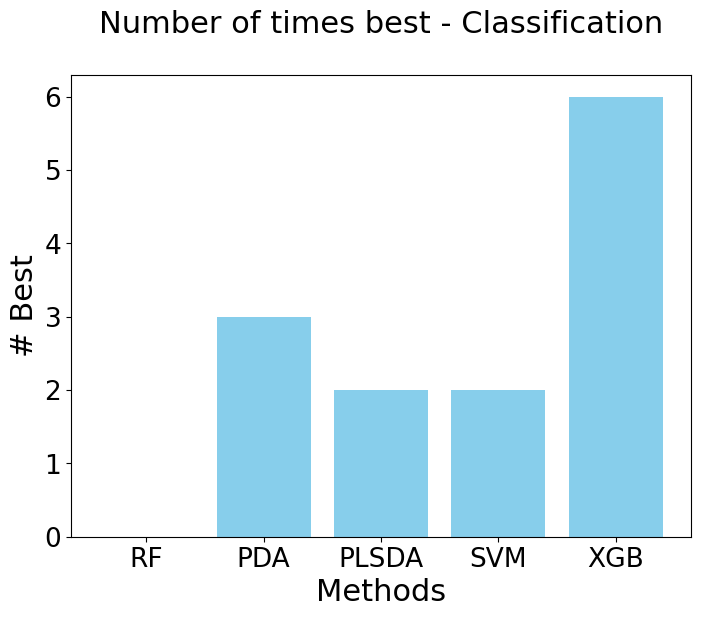

In [5]:
import matplotlib.pyplot as plt

methods = ["RF", "PDA", "PLSDA", "SVM", "XGB"]
wins = [0, 3, 2, 2, 6]

plt.figure(figsize=(8, 6))  # Adjust figure size if needed
plt.bar(methods, wins, color='skyblue')  # Create the bar plot

plt.xlabel("Methods", fontsize=22)  # Increase font size here
plt.ylabel("# Best", fontsize=22)    # Increase font size here
plt.title("Number of times best - Classification\n", fontsize=22) # Increase font size here
plt.xticks(fontsize=19) #increase the x tick fontsize
plt.yticks(fontsize=19) #increase the y tick fontsize

plt.savefig("Best_per_method_classification.pdf")
plt.show()


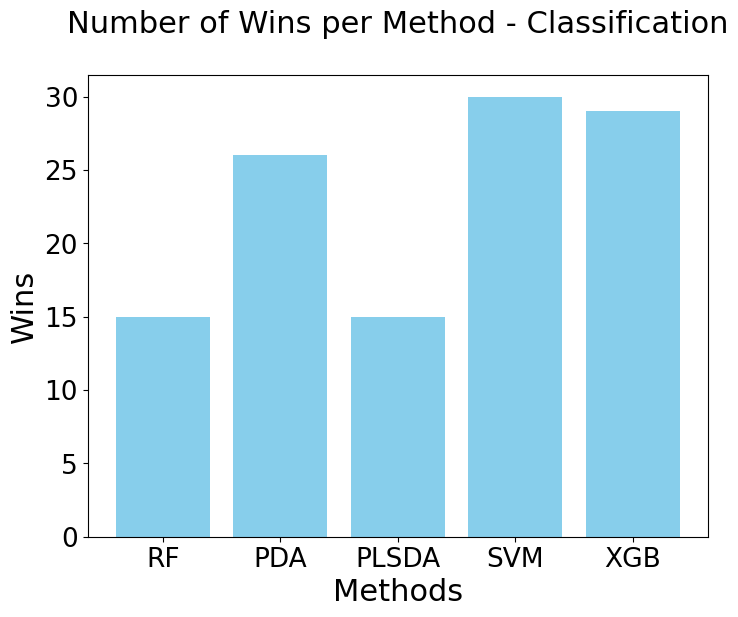

In [3]:
import matplotlib.pyplot as plt

methods = ["RF", "PDA", "PLSDA", "SVM", "XGB"]
wins = [15, 26, 15, 30, 29]

plt.figure(figsize=(8, 6))  # Adjust figure size if needed
plt.bar(methods, wins, color='skyblue')  # Create the bar plot

plt.xlabel("Methods", fontsize=22)  # Increase font size here
plt.ylabel("Wins", fontsize=22)    # Increase font size here
plt.title("Number of Wins per Method - Classification\n", fontsize=22) # Increase font size here
plt.xticks(fontsize=19) #increase the x tick fontsize
plt.yticks(fontsize=19) #increase the y tick fontsize

plt.savefig("wins_per_method_classification.pdf")
plt.show()


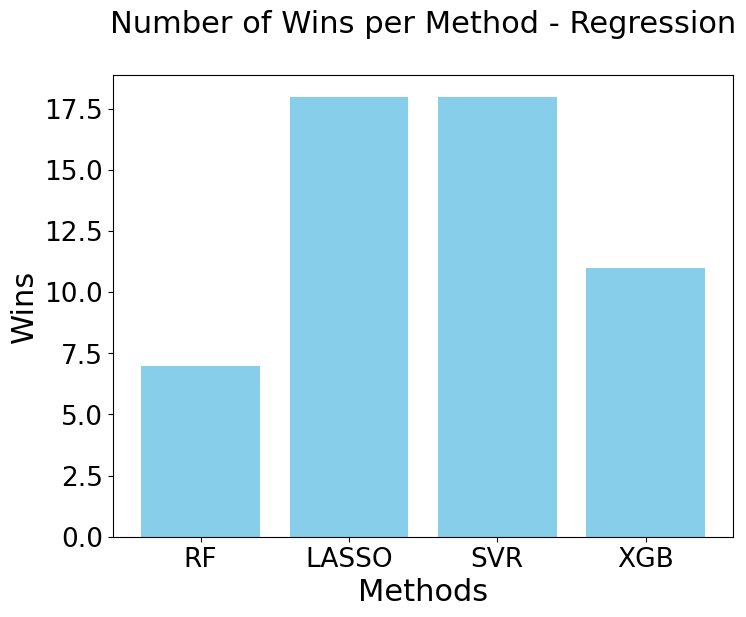

In [6]:
import matplotlib.pyplot as plt

methods = ["RF", "LASSO", "SVR", "XGB"]
wins = [7, 18, 18, 11]


plt.figure(figsize=(8, 6))  # Adjust figure size if needed
plt.bar(methods, wins, color='skyblue')  # Create the bar plot

plt.xlabel("Methods", fontsize=22)  # Increase font size here
plt.ylabel("Wins", fontsize=22)    # Increase font size here
plt.title("Number of Wins per Method - Regression\n", fontsize=22) # Increase font size here
plt.xticks(fontsize=19) #increase the x tick fontsize
plt.yticks(fontsize=19) #increase the y tick fontsize

plt.savefig("wins_per_method_regression.pdf")
plt.show()


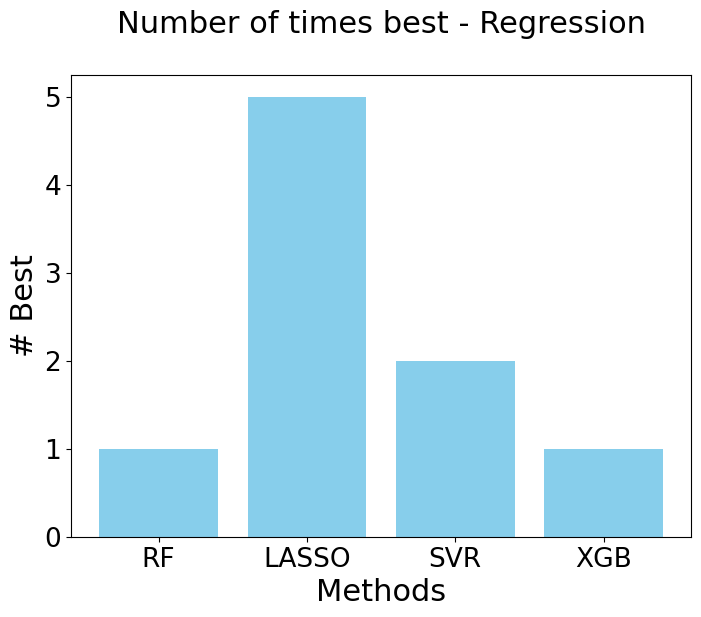

In [7]:
import matplotlib.pyplot as plt

methods = ["RF", "LASSO", "SVR", "XGB"]
wins = [1,5,2,1]


plt.figure(figsize=(8, 6))  # Adjust figure size if needed
plt.bar(methods, wins, color='skyblue')  # Create the bar plot

plt.xlabel("Methods", fontsize=22)  # Increase font size here
plt.ylabel("# Best", fontsize=22)    # Increase font size here
plt.title("Number of times best - Regression\n", fontsize=22) # Increase font size here
plt.xticks(fontsize=19) #increase the x tick fontsize
plt.yticks(fontsize=19) #increase the y tick fontsize

plt.savefig("best_per_method_regression.pdf")
plt.show()
